# SIFT algorithm

SIFT (Scale-Invariant Feature Transform) is an algorithm developped by David Lowe in 1999. It is a worldwide reference for image alignment and object recognition. The robustness of this method enables to detect features at different scales, angles and illumination of a scene. 

*Silx* provides an implementation of SIFT in OpenCL, meaning that it can run on Graphics Processing Units and Central Processing Units as well. This implementation can run on most graphic cards and CPU, making it usable on many setups. OpenCL processes are handled from Python with PyOpenCL, a module to access OpenCL parallel computation API.

Interest points are detected in the image, then data structures called descriptors are built to be characteristic of the scene, so that two different images of the same scene have similar descriptors. They are robust to transformations like translation, rotation, rescaling and illumination change, which make SIFT interesting for image stitching.

In the fist stage, descriptors are computed from the input images. Then, they are compared to determine the geometric transformation to apply in order to align the images. 


# Keypoint extraction

Open a first image and find its characteristic keypoints.


In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


(563, 1000, 3) uint8


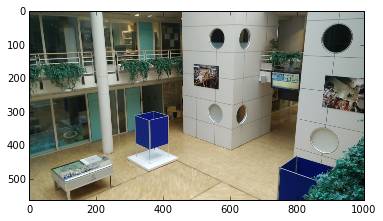

In [2]:
import fabio
image1 = fabio.open("IMG_20170309_083429.tiff").data
imshow(image1)
print(image1.shape, image1.dtype)  # RGB image: 563x1000x3 dtype:uint8

In the following code, replace "CPU" with "GPU" to test parallel computing on your graphics card.

In [3]:
from silx.image import sift
sift_plan = sift.SiftPlan(image1.shape,
                          image1.dtype, 
                          devicetype="CPU")

# Alternative shortcut using template keyword:
# sift_plan = sift.SiftPlan(template=image1, 
#                           devicetype="GPU") 

/usr/lib/python3/dist-packages/pyopencl/__init__.py:61: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


Use the SIFT plan to find keypoints in an image.


In [4]:
# Find keypoints
%time keypoints = sift_plan(image1)

# print information about detected keypoints
print("Number of keypoints: %s" % len(keypoints))
print("Last keypoint's content:")
print(keypoints.dtype)
print("x: %.3f \t y: %.3f \t scale: %.3f \t angle: %.3f" %
      (keypoints[-1].x, 
       keypoints[-1].y, 
       keypoints[-1].scale, 
       keypoints[-1].angle))
print("descriptor:")
print(keypoints[-1].desc)

CPU times: user 3.62 s, sys: 36 ms, total: 3.66 s
Wall time: 514 ms
Number of keypoints: 865
Last keypoint's content:
[('x', '<f4'), ('y', '<f4'), ('scale', '<f4'), ('angle', '<f4'), ('desc', 'u1', (128,))]
x: 546.705 	 y: 307.067 	 scale: 57.177 	 angle: 0.445
descriptor:
[ 34   0   0   4   2   0   1  87  19   0   0  28  74   5  16  97  33   1
   0  62 101   2   1  20  36   3   7   9   9   2   1  18  42   0   1  40
  40   1   3  99 123   6   3  12  25   1   6 123  32   6  28 123 110   2
   0  17  47   4  19  32  17  40  34  39  30  58  47  34  58   5   7  25
 123 123  38   7   4   0   0  30  36  58  85 123  11   0   0   0   1   0
  19 117  84  38  16   2  78 117  31   2   0   0   0   9  30 123  26   0
   0   0   0   1   2  28   9   9   0   0   0   0   0   0   0  10   3   0
   0   0]


Display keypoints on the image:

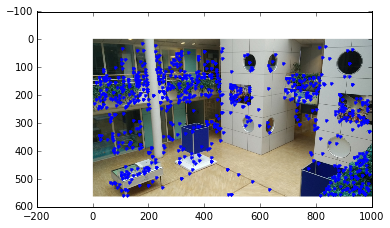

In [5]:
imshow(image1)
plot(keypoints[:].x, keypoints[:].y,".")

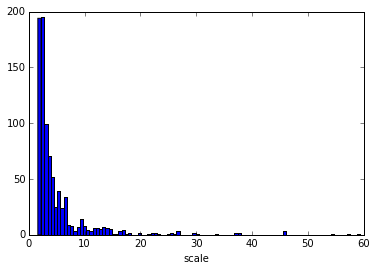

In [6]:
# Diplaying keypoints histogram by scale:
hist(keypoints[:].scale, 100)
xlabel("scale")

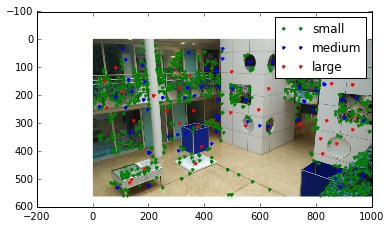

In [7]:
# One can see 3 groups of keypoints, boundaries at: 8 and 16.
# Let's display them in different colors.
S = 8
L = 16
small = keypoints[keypoints[:].scale < S]
medium = keypoints[numpy.logical_and(keypoints[:].scale < L,
                                     keypoints[:].scale >= S)]
bigger = keypoints[keypoints[:].scale >= L]
imshow(image1, cmap="gray")
plot(small[:].x, small[:].y,".g", label="small")
plot(medium[:].x, medium[:].y,".b", label="medium")
plot(bigger[:].x, bigger[:].y,".r", label="large")
legend()

# Keypoint matching


Use your previous SiftPlan to compute keypoints for the second image:

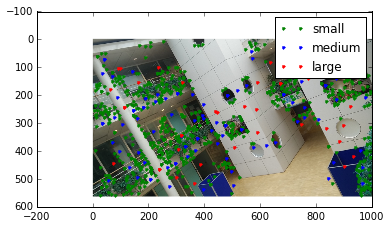

In [8]:
image2 = fabio.open("IMG_20170309_083439.tiff").data
imshow(image2)

# use the same plan to compute keypoints 
# (both images have same size and dtype)
keypoints2 = sift_plan(image2)



# same procedure as previously: show keypoints on image by scale
small2 = keypoints2[keypoints2[:].scale < S]
medium2 = keypoints2[numpy.logical_and(keypoints2[:].scale < L,
                                       keypoints2[:].scale >= S)]
bigger2 = keypoints2[keypoints2[:].scale >= L]
plot(small2[:].x, small2[:].y,".g", label="small")
plot(medium2[:].x, medium2[:].y,".b", label="medium")
plot(bigger2[:].x, bigger2[:].y,".r", label="large")
legend()

Then we can use MatchPlan to find the offset between the two images. The following calculation assumes that images are just translated, not rotated (our example is not ideal).  

In [9]:
mp = sift.MatchPlan()
match = mp(keypoints, keypoints2)
print("Number of Keypoints with for image 1 : %i" % keypoints.size)
print("For image 2 : %i" % keypoints2.size)
print("Matching keypoints: %i" % match.shape[0])
print(match.dtype)
print(match.shape)

from numpy import median
print("Measured offsets dx: %.3f, dy: %.3f" %
      (median(match[:,1].x - match[:,0].x), 
       median(match[:,1].y - match[:,0].y)))

Number of Keypoints with for image 1 : 865
For image 2 : 827
Matching keypoints: 321
[('x', '<f4'), ('y', '<f4'), ('scale', '<f4'), ('angle', '<f4'), ('desc', 'u1', (128,))]
(321, 2)
Measured offsets dx: -14.709, dy: 179.898


# Image alignement


Align image2 with image1, using a translation and a rotation:

/usr/lib/python3/dist-packages/pyopencl/__init__.py:61: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


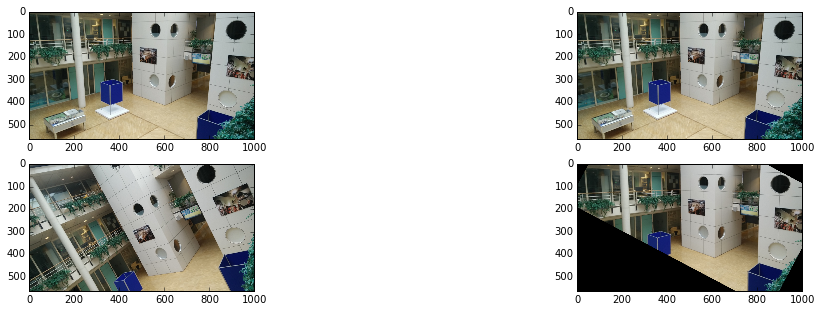

In [10]:
sa = sift.LinearAlign(image1)
image2_aligned = sa.align(image2)

# plot images side by side for visual comparison
figure(figsize=(18,5))
subplot(2,2,1)
imshow(image1)
subplot(2,2,2)
imshow(image1)
subplot(2,2,3)
imshow(image2)
subplot(2,2,4)
imshow(image2_aligned)